In [13]:
import numpy as np
import operator
import matplotlib.pyplot as plt
import cv2 
import sys

target_location = (np.random.randint(14,16), np.random.randint(15,18)) # (14,15)
config = {
    'width': 20,
    'height':20,
    'goal_row':14,
    'goal_col':15,
    'obs_start_row':3,
    'obs_start_col':3,
    'obs_end_row':6,
    'obs_end_col':6,
    'obs2_start_row':8,
    'obs2_start_col':6,
    'obs2_end_row':10,
    'obs2_end_col':9,
    'soft_obs_start_row':10,
    'soft_obs_start_col':10,
    'soft_obs_end_row':15,
    'soft_obs_end_col':14,
    'spaw_start_row': 4,
    'spaw_end_row': 14,
}

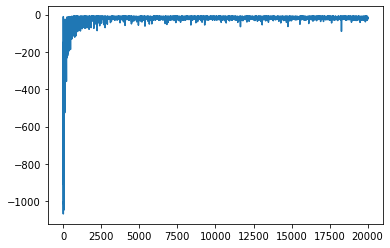

Player location = (4, 1)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 8. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [14]:

class GridEnv:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = config['height']
        self.width = config['width']
        
        self.grid = np.zeros(( self.height, self.width)) - 1
        
        # choose random start position
        self.player_location = (2,6)
        
        # Set locations for the bomb and the gold
        
        self.A_location = ( np.random.randint(4,10), np.random.randint(1,4))
        self.player_location = self.A_location
        #self.B_location = (config['goal_row'],config['goal_col']) # (14,15)
        self.B_location = target_location#(np.random.randint(4,8), 15) # (14,15)
        self.terminal_states = [ self.B_location]
        self.obstacle_start_loc = (config['obs_start_row'],config['obs_start_col']) #(6,4)
        self.obstacle_end_loc = (config['obs_end_row'],config['obs_end_col']) #(10,14)
        self.obstacle_states = []
        for a in range(self.obstacle_start_loc[0],self.obstacle_end_loc[0]+1):
            for b in range(self.obstacle_start_loc[1],self.obstacle_end_loc[1]+1):
                self.obstacle_states.append((b,a))
                self.grid[b, a] = -8
        self.obstacle2_start_loc = (config['obs2_start_row'],config['obs2_start_col']) #(6,4)
        self.obstacle2_end_loc = (config['obs2_end_row'],config['obs2_end_col']) #(10,14)
        self.obstacle2_states = []
        for a in range(self.obstacle2_start_loc[0],self.obstacle2_end_loc[0]+1):
            for b in range(self.obstacle2_start_loc[1],self.obstacle2_end_loc[1]+1):
                self.obstacle2_states.append((b,a))
                self.grid[b, a] = -8
        self.soft_obstacle_states = []
        self.soft_obstacle_start_loc = (config['soft_obs_start_row'],config['soft_obs_start_col']) #(6,4)
        self.soft_obstacle_end_loc = (config['soft_obs_end_row'],config['soft_obs_end_col']) #(10,14)
        for a in range(self.soft_obstacle_start_loc[0],self.soft_obstacle_end_loc[0]+1):
            for b in range(self.soft_obstacle_start_loc[1],self.soft_obstacle_end_loc[1]+1):
                if (b,a) not in self.obstacle_states:
                    self.soft_obstacle_states.append((b,a))
                    self.grid[b, a] = -4 # weight for soft obstacle reward

        # set reward 10 for B as goal location
        self.grid[ self.B_location[0], self.B_location[1]] = 10
        
        # all available action definition
        self.actions = ['LEFT', 'RIGHT', 'UP', 'DOWN']
    
        
    ## Put methods here:
    def get_all_actions(self):
        """Returns all actions"""
        return self.actions
    
    def make_grid_layout(self):
        """Create presentation of grid"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.player_location[0], self.player_location[1]] = 1
        grid[ self.A_location[0], self.A_location[1]] = 8
        grid[ self.B_location[0], self.B_location[1]] = 8
#         for loc in self.obstacle_states:
#             grid[ loc[0], loc[1]] = 3
        return grid
    
    def earn_reward(self, location):
        """get reward"""
        return self.grid[ location[0], location[1]]
        
    

    def step(self, action):
        #remember current location
        old_location = self.player_location
        
        # action is UP
        if action == 'UP':
            # Can not go uo if agent at top
            if old_location[0] == 0:
                reward = self.earn_reward(old_location)
            else:
                self.player_location = ( self.player_location[0] - 1, self.player_location[1])
                if self.player_location in self.obstacle_states or self.player_location in self.obstacle2_states:
                    reward = self.earn_reward(old_location)
                    self.player_location = old_location
                else:
                    if self.player_location in self.soft_obstacle_states:
                        reward = self.earn_reward(self.player_location) / 2
                    else:
                        reward = self.earn_reward(self.player_location)
        
        # action is DOWN
        elif action == 'DOWN':
            # Can not go down if agent at bottom
            if old_location[0] == self.height - 1:
                reward = self.earn_reward(old_location)
            else:
                self.player_location = ( self.player_location[0] + 1, self.player_location[1])
                if self.player_location in self.obstacle_states or self.player_location in self.obstacle2_states:
                    reward = self.earn_reward(old_location)
                    self.player_location = old_location
                else:
                    if self.player_location in self.soft_obstacle_states:
                        reward = self.earn_reward(self.player_location) / 2
                    else:
                        reward = self.earn_reward(self.player_location)
            
        # action is LEFT
        elif action == 'LEFT':
            # Can not go left if agent at left most
            if old_location[1] == 0:
                reward = self.earn_reward(old_location)
            else:
                self.player_location = ( self.player_location[0], self.player_location[1] - 1)
                if self.player_location in self.obstacle_states or self.player_location in self.obstacle2_states:
                    reward = self.earn_reward(old_location)
                    self.player_location = old_location
                else:
                    if self.player_location in self.soft_obstacle_states:
                        reward = self.earn_reward(self.player_location) / 2
                    else:
                        reward = self.earn_reward(self.player_location)

        # action is RIGHT
        elif action == 'RIGHT':
            # Can not go right if agent at right most
            if old_location[1] == self.width - 1:
                reward = self.earn_reward(old_location)
            else:
                self.player_location = ( self.player_location[0], self.player_location[1] + 1)
                if self.player_location in self.obstacle_states or self.player_location in self.obstacle2_states:
                    reward = self.earn_reward(old_location)
                    self.player_location = old_location
                else:
                    if self.player_location in self.soft_obstacle_states:
                        reward = self.earn_reward(self.player_location) / 2
                    else:
                        reward = self.earn_reward(self.player_location)
                
        return reward
    
    def is_terminal_state(self):
        """check if state """
        if self.player_location in self.terminal_states:
            return True
        else:
            return False
class Agent():
    # constructor
    def __init__(self, environment, epsilon=0.1, lr=0.1, gamma=1):
        self.environment = environment
        #using datastructure as dictionary of distionary
        self.Q = dict() 
        #all cells of grid
        for i in range(environment.height): 
            for j in range(environment.width):
                #set probability of move for all action is zero the first time
                self.Q[(i,j)] = { 'LEFT':0, 'RIGHT':0, 'UP':0, 'DOWN':0} 

        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma
        
    def choose_action(self, actions):
        """using epsilon - greedy strategy to chose action"""
        #create uniform random
        if np.random.uniform(0,1) < self.epsilon:
            random_index = np.random.randint(0, len(actions))
            action = actions[random_index]
        else:
            q_values_of_state = self.Q[self.environment.player_location]
            #get max probability of all action if current state
            max_q_value = max(q_values_of_state.values())
            #get action that have that max q value
            action = np.random.choice([action_name for action_name, prob in q_values_of_state.items() if prob == max_q_value])
        return action
    
    def learn(self, state, reward, next_state, action):
        """This function using q learning to update the Q table"""
        q_values_of_next_state = self.Q[next_state]
        max_q_value_in_new_state = max(q_values_of_next_state.values())
        current_q_value = self.Q[state][action]
        
        #calculate target value
        q_target_value = reward + self.gamma * max_q_value_in_new_state
        td_error = q_target_value - current_q_value
        #update current q value of old state
        self.Q[state][action] += self.lr*(td_error)
        
def interact(environment, agent, episodes=1000, max_steps=1000, learn=False):
    """interact with environment and learn from error."""

    rewards_log = [] 
    
    for episode in range(episodes): # Run episodes
        total_reward = 0 
        count_step = 0
        done = False
        while count_step < max_steps and  (not done): 
            state = environment.player_location
            action = agent.choose_action(environment.actions) 
            one_step_reward = environment.step(action)
            next_state = environment.player_location
            
            if learn: 
                #if learn we have to update Q table
                agent.learn(state, one_step_reward, next_state, action)
                
            total_reward += one_step_reward
            count_step += 1
            #check if got terminal state or not
            if environment.is_terminal_state(): 
                environment.__init__()
                done = True     
        #for measurement performance
        rewards_log.append(total_reward) 
        
    return rewards_log 

environment = GridEnv()

agentQ = Agent(environment)

def visualize(start, end, path, ms = 200):
    rows = 200
    cols = 200
    img = np.zeros((rows, cols, 3), dtype = "uint8") #3channel



    step = 21
    x = np.linspace(start=0, stop=rows, num=step)
    y = np.linspace(start=0, stop=cols, num=step)

    

    v_xy = []
    h_xy = []
    for i in range(step):
        v_xy.append( [int(x[i]), 0, int(x[i]), rows-1] )
        h_xy.append( [0, int(y[i]), cols-1, int(y[i])] )


    for i in range(step):
        [x1, y1, x2, y2] = v_xy[i]
        [x1_, y1_, x2_, y2_] = h_xy[i]


        cv2.line(img, (x1,y1), (x2, y2), (0,255,0),1 )
        cv2.line(img, (x1_,y1_), (x2_, y2_), (0,255,0),1 )
    #draw no spaw zone
#     cv2.rectangle(img,(0, config['spaw_start_row']*10),(cols, config['spaw_end_row']*10),(255,0,255),2)
    #draw obstacle
    cv2.rectangle(img,(config['obs_start_col']*10, config['obs_start_row']*10),(config['obs_end_col']*10, config['obs_end_row']*10),(255,0,255), 2)
    cv2.rectangle(img,(config['obs2_start_col']*10, config['obs2_start_row']*10),(config['obs2_end_col']*10, config['obs2_end_row']*10),(255,0,255), 2)
    
    #draw soft obstacle
    cv2.rectangle(img,(config['soft_obs_start_col']*10, config['soft_obs_start_row']*10),(config['soft_obs_end_col']*10, config['soft_obs_end_row']*10), (100,0,100),2)

    
    for loc in path:
        cv2.circle(img,(loc[0]*10+5,loc[1]*10+5), 2, (0,0,255), -1)
    
    cv2.circle(img,(start[0]*10+5,start[1]*10+5), 3, (0,255,255), -1)
    cv2.circle(img,(end[0]*10+5,end[1]*10+5), 3, (0,255,255), -1)
    cv2.namedWindow('img',0)
    cv2.imshow('img', img)
    cv2.waitKey(ms)
# make agent to learn from interact with environment and update q table
rewards_log = interact(environment, agentQ, episodes=20000, learn=True)

# Plot the log of rewards
plt.plot(rewards_log)
plt.show()




agent = agentQ
#dont need random choice
environment.epsilon = 0.0

#this is to run agent for complete espisode and print the path
count = 0
total_reward = 0
optimal_path = []

while (not environment.is_terminal_state() and count< 1000):
    print("Player location =", environment.player_location)
    optimal_path.append(environment.player_location)
    print(environment.make_grid_layout())
    actions = environment.get_all_actions()
    print("Actions =", actions)
    action = agent.choose_action(actions)
    print("Action =", action)
    reward = environment.step(action)
    print("Reward obtained =", reward)
    total_reward = total_reward+ reward
    print("Total obtained =", total_reward)
    visualize(environment.A_location, environment.B_location, optimal_path, 200)
    count = count + 1

visualize(environment.A_location, environment.B_location, optimal_path, 0)





In [27]:
import numpy as np
import operator
import matplotlib.pyplot as plt
import cv2 
import sys

target_location = (3,16) # (14,15)
config = {
    'width': 20,
    'height':20,
    'goal_row':14,
    'goal_col':15,
    'obs_start_row':3,
    'obs_start_col':4,
    'obs_end_row':6,
    'obs_end_col':6,
    'obs2_start_row':8,
    'obs2_start_col':6,
    'obs2_end_row':10,
    'obs2_end_col':9,
    'soft_obs_start_row':12,
    'soft_obs_start_col':3,
    'soft_obs_end_row':13,
    'soft_obs_end_col':14,
    'spaw_start_row': 4,
    'spaw_end_row': 14,
}

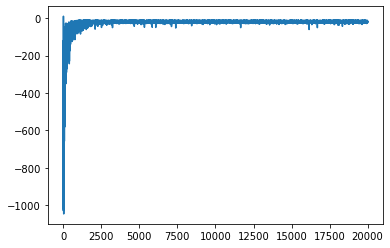

Player location = (14, 1)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 8. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 8. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [29]:

class GridEnv:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = config['height']
        self.width = config['width']
        
        self.grid = np.zeros(( self.height, self.width)) - 1
        
        # choose random start position
        self.player_location = (2,6)
        
        # Set locations for the bomb and the gold
        
        self.A_location = ( np.random.randint(10,17), np.random.randint(1,4))
        self.player_location = self.A_location
        #self.B_location = (config['goal_row'],config['goal_col']) # (14,15)
        self.B_location = target_location#(np.random.randint(4,8), 15) # (14,15)
        self.terminal_states = [ self.B_location]
        self.obstacle_start_loc = (config['obs_start_row'],config['obs_start_col']) #(6,4)
        self.obstacle_end_loc = (config['obs_end_row'],config['obs_end_col']) #(10,14)
        self.obstacle_states = []
        for a in range(self.obstacle_start_loc[0],self.obstacle_end_loc[0]+1):
            for b in range(self.obstacle_start_loc[1],self.obstacle_end_loc[1]+1):
                self.obstacle_states.append((b,a))
                self.grid[b, a] = -8
        self.obstacle2_start_loc = (config['obs2_start_row'],config['obs2_start_col']) #(6,4)
        self.obstacle2_end_loc = (config['obs2_end_row'],config['obs2_end_col']) #(10,14)
        self.obstacle2_states = []
        for a in range(self.obstacle2_start_loc[0],self.obstacle2_end_loc[0]+1):
            for b in range(self.obstacle2_start_loc[1],self.obstacle2_end_loc[1]+1):
                self.obstacle2_states.append((b,a))
                self.grid[b, a] = -8
        self.soft_obstacle_states = []
        self.soft_obstacle_start_loc = (config['soft_obs_start_row'],config['soft_obs_start_col']) #(6,4)
        self.soft_obstacle_end_loc = (config['soft_obs_end_row'],config['soft_obs_end_col']) #(10,14)
        for a in range(self.soft_obstacle_start_loc[0],self.soft_obstacle_end_loc[0]+1):
            for b in range(self.soft_obstacle_start_loc[1],self.soft_obstacle_end_loc[1]+1):
                if (b,a) not in self.obstacle_states:
                    self.soft_obstacle_states.append((b,a))
                    self.grid[b, a] = -4 # weight for soft obstacle reward

        # set reward 10 for B as goal location
        self.grid[ self.B_location[0], self.B_location[1]] = 10
        
        # all available action definition
        self.actions = ['LEFT', 'RIGHT', 'UP', 'DOWN']
    
        
    ## Put methods here:
    def get_all_actions(self):
        """Returns all actions"""
        return self.actions
    
    def make_grid_layout(self):
        """Create presentation of grid"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.player_location[0], self.player_location[1]] = 1
        grid[ self.A_location[0], self.A_location[1]] = 8
        grid[ self.B_location[0], self.B_location[1]] = 8
#         for loc in self.obstacle_states:
#             grid[ loc[0], loc[1]] = 3
        return grid
    
    def earn_reward(self, location):
        """get reward"""
        return self.grid[ location[0], location[1]]
        
    

    def step(self, action):
        #remember current location
        old_location = self.player_location
        
        # action is UP
        if action == 'UP':
            # Can not go uo if agent at top
            if old_location[0] == 0:
                reward = self.earn_reward(old_location)
            else:
                self.player_location = ( self.player_location[0] - 1, self.player_location[1])
                if self.player_location in self.obstacle_states or self.player_location in self.obstacle2_states:
                    reward = self.earn_reward(old_location)
                    self.player_location = old_location
                else:
                    if self.player_location in self.soft_obstacle_states:
                        reward = self.earn_reward(self.player_location) / 2
                    else:
                        reward = self.earn_reward(self.player_location)
        
        # action is DOWN
        elif action == 'DOWN':
            # Can not go down if agent at bottom
            if old_location[0] == self.height - 1:
                reward = self.earn_reward(old_location)
            else:
                self.player_location = ( self.player_location[0] + 1, self.player_location[1])
                if self.player_location in self.obstacle_states or self.player_location in self.obstacle2_states:
                    reward = self.earn_reward(old_location)
                    self.player_location = old_location
                else:
                    if self.player_location in self.soft_obstacle_states:
                        reward = self.earn_reward(self.player_location) / 2
                    else:
                        reward = self.earn_reward(self.player_location)
            
        # action is LEFT
        elif action == 'LEFT':
            # Can not go left if agent at left most
            if old_location[1] == 0:
                reward = self.earn_reward(old_location)
            else:
                self.player_location = ( self.player_location[0], self.player_location[1] - 1)
                if self.player_location in self.obstacle_states or self.player_location in self.obstacle2_states:
                    reward = self.earn_reward(old_location)
                    self.player_location = old_location
                else:
                    if self.player_location in self.soft_obstacle_states:
                        reward = self.earn_reward(self.player_location) / 2
                    else:
                        reward = self.earn_reward(self.player_location)

        # action is RIGHT
        elif action == 'RIGHT':
            # Can not go right if agent at right most
            if old_location[1] == self.width - 1:
                reward = self.earn_reward(old_location)
            else:
                self.player_location = ( self.player_location[0], self.player_location[1] + 1)
                if self.player_location in self.obstacle_states or self.player_location in self.obstacle2_states:
                    reward = self.earn_reward(old_location)
                    self.player_location = old_location
                else:
                    if self.player_location in self.soft_obstacle_states:
                        reward = self.earn_reward(self.player_location) / 2
                    else:
                        reward = self.earn_reward(self.player_location)
                
        return reward
    
    def is_terminal_state(self):
        """check if state """
        if self.player_location in self.terminal_states:
            return True
        else:
            return False
class Agent():
    # constructor
    def __init__(self, environment, epsilon=0.1, lr=0.1, gamma=1):
        self.environment = environment
        #using datastructure as dictionary of distionary
        self.Q = dict() 
        #all cells of grid
        for i in range(environment.height): 
            for j in range(environment.width):
                #set probability of move for all action is zero the first time
                self.Q[(i,j)] = { 'LEFT':0, 'RIGHT':0, 'UP':0, 'DOWN':0} 

        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma
        
    def choose_action(self, actions):
        """using epsilon - greedy strategy to chose action"""
        #create uniform random
        if np.random.uniform(0,1) < self.epsilon:
            random_index = np.random.randint(0, len(actions))
            action = actions[random_index]
        else:
            q_values_of_state = self.Q[self.environment.player_location]
            #get max probability of all action if current state
            max_q_value = max(q_values_of_state.values())
            #get action that have that max q value
            action = np.random.choice([action_name for action_name, prob in q_values_of_state.items() if prob == max_q_value])
        return action
    
    def learn(self, state, reward, next_state, action):
        """This function using q learning to update the Q table"""
        q_values_of_next_state = self.Q[next_state]
        max_q_value_in_new_state = max(q_values_of_next_state.values())
        current_q_value = self.Q[state][action]
        
        #calculate target value
        q_target_value = reward + self.gamma * max_q_value_in_new_state
        td_error = q_target_value - current_q_value
        #update current q value of old state
        self.Q[state][action] += self.lr*(td_error)
        
def interact(environment, agent, episodes=1000, max_steps=1000, learn=False):
    """interact with environment and learn from error."""

    rewards_log = [] 
    
    for episode in range(episodes): # Run episodes
        total_reward = 0 
        count_step = 0
        done = False
        while count_step < max_steps and  (not done): 
            state = environment.player_location
            action = agent.choose_action(environment.actions) 
            one_step_reward = environment.step(action)
            next_state = environment.player_location
            
            if learn: 
                #if learn we have to update Q table
                agent.learn(state, one_step_reward, next_state, action)
                
            total_reward += one_step_reward
            count_step += 1
            #check if got terminal state or not
            if environment.is_terminal_state(): 
                environment.__init__()
                done = True     
        #for measurement performance
        rewards_log.append(total_reward) 
        
    return rewards_log 

environment = GridEnv()

agentQ = Agent(environment)

def visualize(start, end, path, ms = 200):
    rows = 200
    cols = 200
    img = np.zeros((rows, cols, 3), dtype = "uint8") #3channel



    step = 21
    x = np.linspace(start=0, stop=rows, num=step)
    y = np.linspace(start=0, stop=cols, num=step)

    

    v_xy = []
    h_xy = []
    for i in range(step):
        v_xy.append( [int(x[i]), 0, int(x[i]), rows-1] )
        h_xy.append( [0, int(y[i]), cols-1, int(y[i])] )


    for i in range(step):
        [x1, y1, x2, y2] = v_xy[i]
        [x1_, y1_, x2_, y2_] = h_xy[i]


        cv2.line(img, (x1,y1), (x2, y2), (0,255,0),1 )
        cv2.line(img, (x1_,y1_), (x2_, y2_), (0,255,0),1 )
    #draw no spaw zone
#     cv2.rectangle(img,(0, config['spaw_start_row']*10),(cols, config['spaw_end_row']*10),(255,0,255),2)
    #draw obstacle
    cv2.rectangle(img,(config['obs_start_col']*10, config['obs_start_row']*10),(config['obs_end_col']*10, config['obs_end_row']*10),(255,0,255), 2)
    cv2.rectangle(img,(config['obs2_start_col']*10, config['obs2_start_row']*10),(config['obs2_end_col']*10, config['obs2_end_row']*10),(255,0,255), 2)
    
    #draw soft obstacle
    cv2.rectangle(img,(config['soft_obs_start_col']*10, config['soft_obs_start_row']*10),(config['soft_obs_end_col']*10, config['soft_obs_end_row']*10), (100,0,100),2)

    
    for loc in path:
        cv2.circle(img,(loc[0]*10+5,loc[1]*10+5), 2, (0,0,255), -1)
    
    cv2.circle(img,(start[0]*10+5,start[1]*10+5), 3, (0,255,255), -1)
    cv2.circle(img,(end[0]*10+5,end[1]*10+5), 3, (0,255,255), -1)
    cv2.namedWindow('img',0)
    cv2.imshow('img', img)
    cv2.waitKey(ms)
# make agent to learn from interact with environment and update q table
rewards_log = interact(environment, agentQ, episodes=20000, learn=True)

# Plot the log of rewards
plt.plot(rewards_log)
plt.show()




agent = agentQ
#dont need random choice
environment.epsilon = 0.0

#this is to run agent for complete espisode and print the path
count = 0
total_reward = 0
optimal_path = []

while (not environment.is_terminal_state() and count< 1000):
    print("Player location =", environment.player_location)
    optimal_path.append(environment.player_location)
    print(environment.make_grid_layout())
    actions = environment.get_all_actions()
    print("Actions =", actions)
    action = agent.choose_action(actions)
    print("Action =", action)
    reward = environment.step(action)
    print("Reward obtained =", reward)
    total_reward = total_reward+ reward
    print("Total obtained =", total_reward)
    visualize(environment.A_location, environment.B_location, optimal_path, 200)
    count = count + 1

visualize(environment.A_location, environment.B_location, optimal_path, 0)



